In [8]:
from Game.BlackJack import BlackJack
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

## 1. Simulation and Labeled Data Generation
> In this part, we generate the labeled data for the training of the model. We will simulate the game process and generate the training data simultaneously. The data will be stored in a csv file for the training of the model.

In [14]:
rounds = 40000
num_decks = 1

dealer_card_feature = []
player_card_feature = []
player_live_total = []
player_live_action = []
player_results = []
dealer_bust = []

first_game = True
prev_round = 0
stack_num_list = []
new_stack = []
card_count_list = []
games_played_with_stack = []

for round in trange(rounds):
    games_played = 0
    
    # Make a dict for keeping track of the count for a stack
    
    game = BlackJack()
    
    while len(game.deck) > 20:

        game.start()
        curr_player_results = None
        
        dealer_hand = []
        player_hands = []
        live_total = []
        live_action = []

       
        
        # Record the player's live total after cards are dealt
        live_total.append(game.get_playervalue())
        
        if round < rounds / 2:
            hit_stay = "hit"
            action = 1
        else:
            hit_stay = "stay"
            action = 0
        
        game.play(hit_stay, "basic")
        
        dealer_value = game.get_dealervalue()
        player_value = game.get_playervalue()
        if dealer_value > 21:
            dealer_bust.append(1)
            if player_value > 21:
                curr_player_results = 0
            else:
                curr_player_results = 1
        else:
            dealer_bust.append(0)
            if player_value > 21:
                curr_player_results = -1
            elif player_value > dealer_value:
                curr_player_results = 1
            elif player_value == dealer_value:
                curr_player_results = 0
            else:
                curr_player_results = -1

        # Track features
        dealer_card_feature.append(game.dealer_hand[0]['number'])
        player_card_feature.append(game.player_hand.copy())
        player_results.append(curr_player_results)
        # player_live_total.append(live_total)
        player_live_action.append(action)
        
        # Update card count list with most recent game's card count
        if round != prev_round:
            new_stack.append(1)
        else:
            new_stack.append(0)
            if first_game == True:
                first_game = False
            else:
                games_played += 1
            
        stack_num_list.append(round)
        games_played_with_stack.append(games_played)
        card_count_list.append(game.card_count.copy())
        prev_round = round

        
    game.reset()
        
        
        
model_df = pd.DataFrame()
model_df['dealer_card'] = dealer_card_feature
model_df['player_total_initial'] = [game.total_value(i[:2]) for i in player_card_feature]
model_df['hit?'] = player_live_action

has_ace = []
for i in player_card_feature:
    if ('A' in [card['number'] for card in i]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace
dealer_card_num = []
for i in model_df['dealer_card']:
    if i=='A':
        dealer_card_num.append(11)
    elif i in ['J', 'Q', 'K']:
        dealer_card_num.append(10)
    else:
        dealer_card_num.append(i)
model_df['dealer_card_num'] = dealer_card_num

model_df['Y'] = player_results
lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

correct = []
for i, val in enumerate(model_df['lose']):
    if val == 1:
        if player_live_action[i] == 1:
            correct.append(0)
        else:
            correct.append(1)
    else:
        if player_live_action[i] == 1:
            correct.append(1)
        else:
            correct.append(0)
model_df['correct_action'] = correct
card_count_df = pd.concat([pd.DataFrame(new_stack, columns=['new_stack']),
                           pd.DataFrame(games_played_with_stack, columns=['games_played_with_stack']),
                           pd.DataFrame.from_dict(card_count_list),
                           pd.DataFrame(dealer_bust, columns=['dealer_bust'])], axis=1)
model_df = pd.concat([model_df, card_count_df], axis=1)

100%|██████████| 40000/40000 [00:02<00:00, 17014.12it/s]


In [15]:
print(len(model_df.columns))
model_df.to_csv("./Data/blackjack_simulation_data.csv", index=False)

21


## 2. Model Evalutation
> In this part, we will test different agents on the environment and compare their performance from different aspects.

### 2.1 Win Rate
We will test 10000 games for each agent and calculate the win rate of each agent.

In [19]:

from Game.BlackJack import BlackJack
from Agent.random.randomagent import RandomAgent
from Agent.nn.nnagent import nnAgent
from Agent.LLM.LLM_Agent import LLMAgent
from Agent.base.baseAgent import BaseAgent
from Agent.qlearning.qLearningAgent import qLearningAgent
from Agent.expectimax.expectimaxAgent import ExpectimaxAgent
from Agent.MDP.MDPagent import MDPAgent

In [24]:
# agent = nnAgent()

agents = [RandomAgent(), BaseAgent(), ExpectimaxAgent(), MDPAgent(), qLearningAgent(), nnAgent()]

In [25]:

rounds = 10000
rates = {}
for agent in agents:
    game = BlackJack("novel")
    results = {"win": 0, "lose": 0, "draw": 0}
    for i in trange(rounds):
        game.start()
        # print("Dealer shows:", game.format_cards(game.dealer_hand[:1]))
        while game.status == "continue":
            action = agent.choose_action(game)
            game.play(action, "basic")
            if action == "stay":
                break
        # print(f"dealer's hand: {game.format_cards(game.dealer_hand)} {game.get_dealervalue()}  player's hand: {game.format_cards(game.player_hand)} {game.get_playervalue()}")
        results[game.game_result()] += 1
        
        if len(game.deck) < 20:
            game.reset()
        
    rates[agent.__class__.__name__] = results["win"] / rounds
## Draw the bar chart of the win rate, lose rate, and draw rate



100%|██████████| 10000/10000 [00:13<00:00, 764.78it/s]


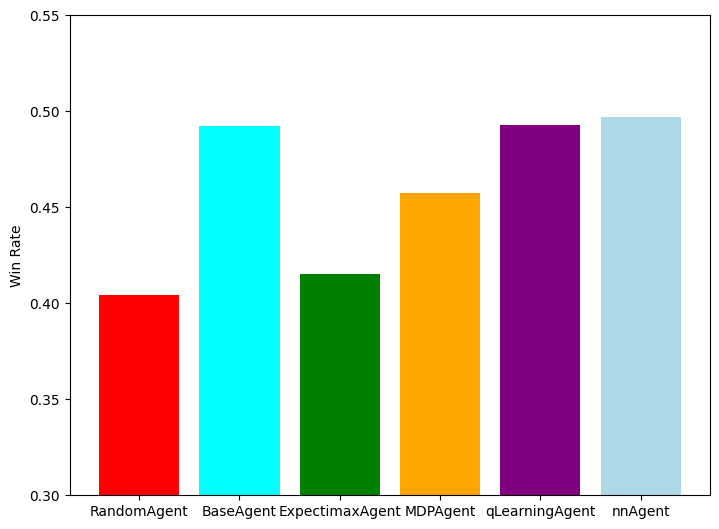

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
colors = ['red', 'cyan', 'green', 'orange', 'purple', "LightBlue"]
ax.bar(rates.keys(), rates.values(), color=colors)
ax.set_ylim(0.3, 0.55) 
plt.ylabel('Win Rate')
plt.show()

In [27]:
rates

{'RandomAgent': 0.4041,
 'BaseAgent': 0.4922,
 'ExpectimaxAgent': 0.4153,
 'MDPAgent': 0.4576,
 'qLearningAgent': 0.4931,
 'nnAgent': 0.497}